# Automated Machine Learning with H2O AutoML for Bliss Window Prediction

## Σύνοψη Διαδικασίας

Αυτό το notebook εφαρμόζει **AutoML (Automated Machine Learning)** χρησιμοποιώντας την πλατφόρμα **H2O.ai** για την πρόβλεψη του Bliss Window. Ενώ το προηγούμενο notebook  χρησιμοποιούσε **manual machine learning** με χειροκίνητη επιλογή αλγορίθμων, hyperparameter tuning, και feature selection, εδώ αξιοποιούμε το **H2O AutoML** που αυτοματοποιεί όλη αυτή τη διαδικασία.

Ο στόχος είναι να **συγκρίνουμε** την απόδοση του AutoML approach με το manual approach και να αξιολογήσουμε αν μπορούμε να επιτύχουμε παρόμοια ή καλύτερα αποτελέσματα με σημαντικά λιγότερη προγραμματιστική προσπάθεια. Το AutoML είναι ιδιαίτερα χρήσιμο όταν:
- Δεν υπάρχει βαθιά εξειδίκευση στο machine learning
- Ο χρόνος ανάπτυξης είναι περιορισμένος
- Θέλουμε να εξερευνήσουμε ευρύ φάσμα αλγορίθμων γρήγορα
- Χρειαζόμαστε baseline για σύγκριση με custom solutions

## H2O Platform και Αρχιτεκτονική

Το **H2O** είναι ένα open-source, distributed machine learning platform σχεδιασμένο για:
- **In-memory processing**: Όλα τα δεδομένα φορτώνονται στη RAM για ταχύτητα
- **Distributed computing**: Μπορεί να scale σε clusters για μεγάλα datasets
- **Multiple languages**: API για Python, R, Java, Scala
- **Web UI (Flow)**: Graphical interface για interactive analysis

### H2O Initialization
```python
h2o.init()
```

Αυτή η εντολή:
- Ξεκινά ένα **H2O cluster** (default: τοπικά στο machine)
- Ελέγχει διαθέσιμη μνήμη και CPU cores
- Δημιουργεί connection στο H2O backend
- Εμφανίζει cluster information (version, nodes, memory)

Το H2O χρησιμοποιεί τη δική του **in-memory data structure** (H2OFrame) αντί για pandas DataFrame, βελτιστοποιημένη για distributed computing.

## H2O AutoML: Πώς Λειτουργεί

Το **H2O AutoML** είναι ένα automated pipeline που:

### 1. Algorithm Selection
Δοκιμάζει αυτόματα **πολλαπλούς αλγορίθμους**:
- **GLM (Generalized Linear Models)**: Linear/Logistic regression με regularization
- **Distributed Random Forest (DRF)**: Παράλληλο Random Forest
- **Gradient Boosting Machine (GBM)**: H2O's implementation
- **XGBoost**: Εξωτερική βιβλιοθήκη ενσωματωμένη
- **Deep Learning**: Neural networks με multiple layers
- **Stacked Ensembles**: Meta-learners που συνδυάζουν τα παραπάνω

### 2. Hyperparameter Optimization
Για κάθε αλγόριθμο, εκτελεί:
- **Random grid search**: Δειγματοληψία από hyperparameter space
- **Bayesian optimization**: Intelligent search για βέλτιστους συνδυασμούς
- **Early stopping**: Σταματά models που δεν βελτιώνονται

### 3. Ensemble Creation
Δημιουργεί **Stacked Ensemble models**:
- **Base learners**: Τα καλύτερα μοντέλα από κάθε αλγόριθμο
- **Meta-learner**: GLM ή GBM που μαθαίνει να συνδυάζει τις προβλέψεις
- Συνήθως τα ensembles είναι τα κορυφαία models στο leaderboard

### 4. Leaderboard Ranking
Όλα τα μοντέλα ταξινομούνται σε **leaderboard** με βάση:
- Default metric για regression: **RMSE (Root Mean Squared Error)**
- Άλλα metrics: MAE, RMSLE, Mean Residual Deviance
- Cross-validation scores για αξιολόγηση generalization

## Experiment 1: Full Dataset με Όλα τα Features

Το πρώτο experiment φορτώνει το πλήρες preprocessed dataset:
```python
df = h2o.import_file('df_ml_model.csv')
```

**Χαρακτηριστικά:**
- Όλες οι one-hot encoded στήλες (cancer_type, tissue)
- Target-encoded cellline_name
- Scaled αριθμητικές μεταβλητές
- TPM values

**Split Strategy:**
```python
train, test = df.split_frame(ratios=[.8], seed=42)
```
- 80% training, 20% test
- `seed=42` για reproducibility
- Το H2O κάνει αυτόματα stratification αν χρειάζεται

**AutoML Configuration:**
```python
aml = H2OAutoML(max_runtime_secs=1200, seed=42, project_name="bliss_window_prediction")
```
- **max_runtime_secs=1200**: Όριο 20 λεπτών για training
- **project_name**: Identifier για tracking experiments
- Χωρίς explicit `max_models`, τρέχει όσα μοντέλα χωρούν στο time budget

**Αποτελέσματα:**
Το leaderboard εμφανίζει τα μοντέλα ταξινομημένα. Τυπικά, θα δούμε:
1. **Stacked Ensembles** στις πρώτες θέσεις (StackedEnsemble_BestOfFamily, StackedEnsemble_AllModels)
2. **GBM/XGBoost** models με διαφορετικές παραμέτρους
3. **Deep Learning** networks αν υπάρχει χρόνος
4. **GLM** ως baseline

Το `aml.leader` αναφέρεται αυτόματα στο κορυφαίο μοντέλο για predictions και explanation.

## Experiment 2: Χωρίς Cellline Name (Addressing Overfitting)

Βασισμένοι στα **ευρήματα του manual ML notebook** όπου το `cellline_name` είχε υπερβολικά υψηλή feature importance και προκαλούσε overfitting:

```python
df_updated = df.drop('cellline_name')
```

**Λογική:**
- Το cellline_name ήταν target-encoded με το bliss_window
- Κάθε cellline είχε λίγες παρατηρήσεις → το μοντέλο "απομνημονεύει" αντί να γενικεύει
- Αφαιρώντας το, αναγκάζουμε το μοντέλο να μάθει από **βιολογικά χαρακτηριστικά**

**Προσδοκίες:**
- **Μικρότερο training performance** (το μοντέλο δεν μπορεί να "cheat")
- **Καλύτερη generalization** σε νέες celllines που δεν υπάρχουν στο training set
- **Πιο interpretable** predictions βασισμένες σε cancer_type, tissue, drug properties

Αυτό είναι το **πιο ρεαλιστικό σενάριο** για production: πρόβλεψη σε νέες, άγνωστες κυτταρικές σειρές.

## Experiment 3: Top 14 Features (Feature Selection)

Χρησιμοποιώντας τα **insights από το manual ML**:

```python
columns_to_keep = ['bliss_window', 'combo_maxe', 'day1_intensity_mean', 'drug1_ic50_ln', 
                   'tpm_value', 'drug2_maxe', 'cancer_type_Lung Adenocarcinoma', 'drug2_ic50_ln',
                   'drug1_maxe', 'day1_viability_mean', 'day1_inhibition_scale', 
                   'growth_rate', 'doubling_time', 'tissue_Lung', 'cancer_type_Colorectal Carcinoma']
```

**Feature Selection Strategy:**
- Κρατούνται τα **top 14 χαρακτηριστικά** από το feature importance analysis του Random Forest
- Αφαιρούνται περιττές one-hot encoded στήλες με χαμηλή importance
- Μειώνεται η διαστατικότητα → λιγότερος κίνδυνος overfitting

**Πλεονεκτήματα:**
- **Ταχύτερο training**: Λιγότερα features → γρηγορότερα μοντέλα
- **Καλύτερη interpretability**: Εστίαση σε σημαντικά features
- **Μείωση noise**: Αφαίρεση features με χαμηλή προβλεπτική ισχύ
- **Reduced overfitting**: Λιγότεροι βαθμοί ελευθερίας

**Δύο Runs:**
1. **20 λεπτά** (`max_runtime_secs=1200`): Quick exploration
2. **1 ώρα** (`max_runtime_secs=3600`): Deeper search, περισσότερα ensembles

Το extended runtime επιτρέπει:
- Περισσότερες hyperparameter combinations
- Πιο σύνθετα ensemble models
- Better convergence για deep learning
- Πιο εκτενές cross-validation

## Experiment 4: Reduced Dataset (11 Features)

Περαιτέρω μείωση αφαιρώντας τις cancer/tissue one-hot features:

```python
columns_to_keep = ['bliss_window', 'combo_maxe', 'day1_intensity_mean', 'drug1_ic50_ln', 
                   'tpm_value', 'drug2_maxe', 'drug2_ic50_ln', 'drug1_maxe', 
                   'day1_viability_mean', 'day1_inhibition_scale', 'growth_rate', 'doubling_time']
```

**Αφαιρούνται:**
- `cancer_type_Lung Adenocarcinoma`
- `tissue_Lung`
- `cancer_type_Colorectal Carcinoma`

**Στόχος:**
- Test αν τα **continuous biological features** (day1 measurements, growth rate, TPM) είναι αρκετά
- Maximum simplicity για **production deployment**
- Μοντέλο που δεν εξαρτάται από categorical features που μπορεί να λείπουν

**Trade-off:**
- Χάνουμε information για cancer type specificity
- Απλούστερο μοντέλο με δυνητικά καλύτερη generalization
- Ιδανικό αν θέλουμε universal predictor across cancer types

Και εδώ δοκιμάζονται **δύο runtime configurations** (20 min vs 1 hour) για σύγκριση.

## AutoML vs Manual ML: Σύγκριση Προσεγγίσεων

| Aspect | Manual ML (ml_model_msc.ipynb) | AutoML (auto_ml.ipynb) |
|--------|-------------------------------|------------------------|
| **Algorithm Selection** | Χειροκίνητη (Linear, RF, GBM, XGBoost) | Αυτόματη (10+ αλγόριθμοι) |
| **Hyperparameter Tuning** | GridSearch, RandomizedSearch, Bayesian | Αυτόματο με intelligent search |
| **Feature Engineering** | Manual feature importance analysis | Αυτόματο (but we apply manual insights) |
| **Ensemble Creation** | Όχι (single models) | Ναι (Stacked Ensembles) |
| **Time Required** | ~2-3 ώρες development | ~20-60 λεπτά runtime |
| **Expertise Needed** | Υψηλή (ML knowledge) | Χαμηλή (basic understanding) |
| **Interpretability** | Πλήρης έλεγχος | Μειωμένος (αλλά υπάρχει explain) |
| **Reproducibility** | Πλήρης | Πλήρης (με seed) |
| **Scalability** | Manual code updates | Αυτόματο scaling με H2O |

## H2O Explain: Automated Model Interpretation

Το H2O παρέχει **comprehensive explanation** με μία εντολή:

```python
h2o.explain(aml.leader, test)
```

Αυτό δημιουργεί αυτόματα:

### 1. Variable Importance Plot
- Bar plot των σημαντικότερων features
- Normalized scores για σύγκριση
- Παρόμοιο με το manual feature_importances αλλά model-agnostic

### 2. Partial Dependence Plots (PDP)
- Πώς αλλάζει η πρόβλεψη καθώς ποικίλλει ένα feature
- Κρατώντας τα άλλα features σταθερά
- Αποκαλύπτει **non-linear relationships**

### 3. SHAP Summary Plot (αν διαθέσιμο)
- **SHapley Additive exPlanations**
- Contribution κάθε feature σε κάθε prediction
- Global feature importance + direction of effect

### 4. Residuals Analysis
- Distribution των σφαλμάτων
- Residual vs Fitted plots για heteroscedasticity check

### 5. Learning Curve
- Training vs validation error over time
- Εντοπισμός overfitting/underfitting

Αυτά τα visualizations είναι **automatic** και δεν χρειάζονται custom code όπως στο manual approach.

## Metrics Comparison και Best Model Selection

Μετά από όλα τα experiments, συγκρίνουμε:

### Metrics να Παρατηρηθούν:
1. **RMSE**: Root Mean Squared Error - primary metric
2. **MAE**: Mean Absolute Error - robust σε outliers
3. **R²**: Coefficient of determination - explained variance
4. **Training vs Validation gap**: Ένδειξη overfitting

### Decision Criteria:
- **Best validation performance**: Το μοντέλο με χαμηλότερο validation RMSE
- **Simplicity**: Προτίμηση σε reduced datasets αν η απόδοση είναι παρόμοια
- **Interpretability**: GLM/GBM vs Deep Learning black boxes
- **Production feasibility**: Feature availability στο deployment environment

### Expected Findings:
- **Experiment 1** (full features): Πιθανότατα καλύτερο RMSE αλλά risk overfitting
- **Experiment 2** (no cellline): Πιο γενικεύσιμο, χαμηλότερο training score
- **Experiment 3** (top 14): Sweet spot - καλή απόδοση με λιγότερα features
- **Experiment 4** (11 features): Simplest, αλλά μπορεί να χάνει πληροφορία

## Σύνδεση με το Συνολικό Pipeline

Το AutoML notebook είναι το **τελικό βήμα** στο ML pipeline:

1. **Graph ETL** → Raw data από Neo4j
2. **Data Aggregation** → Trial-based compression
3. **Data Cleaning** → Preprocessing, scaling, encoding
4. **Manual ML** → Feature selection, algorithm comparison → **Insights**
5. **AutoML** ← Εφαρμογή insights με automated approach → **Production model**

Τα **insights από το manual ML** (π.χ. cellline overfitting, top features) πληροφορούν τα **experiments στο AutoML**, δημιουργώντας ένα **hybrid approach** που συνδυάζει:
- Human expertise (feature selection, problem understanding)
- Machine automation (algorithm selection, hyperparameter tuning)

Το τελικό μοντέλο από το AutoML μπορεί να εξαχθεί ως:
- **MOJO (Model Object, Optimized)**: Low-latency predictions σε production
- **POJO (Plain Old Java Object)**: Java deployment
- **Python object**: Integration σε existing Python apps

Αυτός ο combined workflow επιτυγχάνει το **best of both worlds**: την interpretability και control του manual ML με την efficiency και breadth του AutoML.

In [1]:
import h2o
from h2o.automl import H2OAutoML

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.202-b08, mixed mode)
  Starting server from C:\Users\chrisk41\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\chrisk41\AppData\Local\Temp\1\tmpfvihw54b
  JVM stdout: C:\Users\chrisk41\AppData\Local\Temp\1\tmpfvihw54b\h2o_CHRISK41_started_from_python.out
  JVM stderr: C:\Users\chrisk41\AppData\Local\Temp\1\tmpfvihw54b\h2o_CHRISK41_started_from_python.err


c:\Users\chrisk41\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\backend\server.py:395: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,38 secs
H2O_cluster_timezone:,Europe/Athens
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 18 days
H2O_cluster_name:,H2O_from_python_CHRISK41_vjlocl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,241.2 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [39]:
df = h2o.import_file('df_ml_model.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [40]:
df.columns

['bliss_window',
 'combo_maxe',
 'day1_inhibition_scale',
 'day1_intensity_mean',
 'day1_viability_mean',
 'doubling_time',
 'drug1_ic50_ln',
 'drug1_maxe',
 'drug2_ic50_ln',
 'drug2_maxe',
 'growth_rate',
 'cellline_name',
 'tpm_value',
 "cancer_type_B-Cell Non-Hodgkin's Lymphoma",
 'cancer_type_B-Lymphoblastic Leukemia',
 'cancer_type_Biliary Tract Carcinoma',
 'cancer_type_Bladder Carcinoma',
 'cancer_type_Breast Carcinoma',
 "cancer_type_Burkitt's Lymphoma",
 'cancer_type_Cervical Carcinoma',
 'cancer_type_Chondrosarcoma',
 'cancer_type_Chronic Myelogenous Leukemia',
 'cancer_type_Colorectal Carcinoma',
 'cancer_type_Endometrial Carcinoma',
 'cancer_type_Esophageal Adenocarcinoma',
 'cancer_type_Esophageal Squamous Cell Carcinoma',
 "cancer_type_Ewing's Sarcoma",
 'cancer_type_Gastric Carcinoma',
 'cancer_type_Glioblastoma',
 'cancer_type_Head and Neck Carcinoma',
 'cancer_type_Hepatocellular Carcinoma',
 "cancer_type_Hodgkin's Lymphoma",
 'cancer_type_Kidney Carcinoma',
 'cancer_t

In [41]:
train, test = df.split_frame(ratios=[.8], seed=42)

In [42]:
target_column = 'bliss_window'
x=train.columns
x.remove(target_column)

In [43]:
aml = H2OAutoML(max_runtime_secs=1200, seed=42,project_name="bliss_window_prediction")
aml.train(x=x, y=target_column, training_frame=train)

AutoML progress: |
16:00:34.792: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20250910_160034_model_25


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    45                 45                          29596                  8            11           10.5556       17            60            47.6

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.022622108350114738
RMSE: 0.15040647708830474
MAE: 0.07262603122336393
RMSLE: NaN
Mean Residual Deviance: 0.022622108350114738

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.07698872183121452
RMSE: 0.27746841591650484
MAE: 0.14581157978036932
RMSLE: NaN
Mean Residual Deviance: 0.07698872183121452

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0          nan           nan           nan           nan           nan
loglikelihood           nan        0          nan           nan           nan           nan           nan
mae                     0.145912   0.0137132  0.13724       0.157522      0.139673      0.16334       0.131786
mean_residual_deviance  0.0785555  0.0234062  0.0648955     0.0845034     0.0635185     0.117175      0.0626853
mse                     0.0785555  0.0234062  0.0648955     0.0845034     0.0635185     0.117175      0.0626853
r2                      0.873151   0.0352578  0.895374      0.880423      0.878332      0.812238      0.899389
residual_deviance       0.0785555  0.0234062  0.0648955     0.0845034     0.0635185     0.117175      0.0626853
rmse                    0.27803    0.0396086  0.254746      0.290695      0.252029      0.342308      0.25037
rmsle                   nan        0          nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2025-09-10 16:10:39  8 min  9.994 sec  0                  0.790213         0.615079        0.624437
    2025-09-10 16:10:39  8 min 10.292 sec  5                  0.511972         0.390154        0.262115
    2025-09-10 16:10:39  8 min 10.593 sec  10                 0.354041         0.258187        0.125345
    2025-09-10 16:10:40  8 min 10.899 sec  15                 0.267235         0.179581        0.0714148
    2025-09-10 16:10:40  8 min 11.174 sec  20                 0.221487         0.131891        0.0490565
    2025-09-10 16:10:40  8 min 11.511 sec  25                 0.19389          0.107283        0.0375933
    2025-09-10 16:10:40  8 min 11.813 sec  30                 0.176882         0.0918732       0.0312872
    2025-09-10 16:10:41  8 min 12.075 sec  35                 0.167439         0.0824454       0.0280357
    2025-09-10 16:10:41  8 min 12.364 sec  40                 0.157678         0.0761895       0.0248623
    2025-09-10 16:10:41  8 min 12.631 sec  45                 0.150406         0.072626        0.0226221

Variable Importances: 
variable                          relative_importance    scaled_importance      percentage
--------------------------------  ---------------------  ---------------------  ---------------------
cellline_name                     1632.18310546875       1.0                    0.8943495163409348
combo_maxe                        36.458133697509766     0.02233703655879913    0.019977117842851784
drug1_maxe                  

In [44]:
lb = aml.leaderboard
print(lb)

model_id                                                     rmse        mse       mae    rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20250910_160034_model_25             0.277468  0.0769887  0.145812      nan                 0.0769887
StackedEnsemble_BestOfFamily_4_AutoML_1_20250910_160034  0.277731  0.0771346  0.144935      nan                 0.0771346
StackedEnsemble_BestOfFamily_3_AutoML_1_20250910_160034  0.281422  0.0791984  0.148556      nan                 0.0791984
StackedEnsemble_AllModels_2_AutoML_1_20250910_160034     0.281919  0.0794784  0.14733       nan                 0.0794784
GBM_grid_1_AutoML_1_20250910_160034_model_1              0.283986  0.0806481  0.148208      nan                 0.0806481
GBM_4_AutoML_1_20250910_160034                           0.285662  0.0816028  0.150722      nan                 0.0816028
GBM_grid_1_AutoML_1_20250910_160034_model_31             0.285758  0.0816578  0.134663      nan                 0.0816578
GBM_grid_1_AutoML_1_2025

In [45]:
preds = aml.predict(test)
print(preds.head())

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
   predict
-0.0190998
 0.385099
-0.0691101
 0.0190268
-0.13283
-0.223255
 0.315583
 0.240271
 0.715148
 0.833983
[10 rows x 1 column]



# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

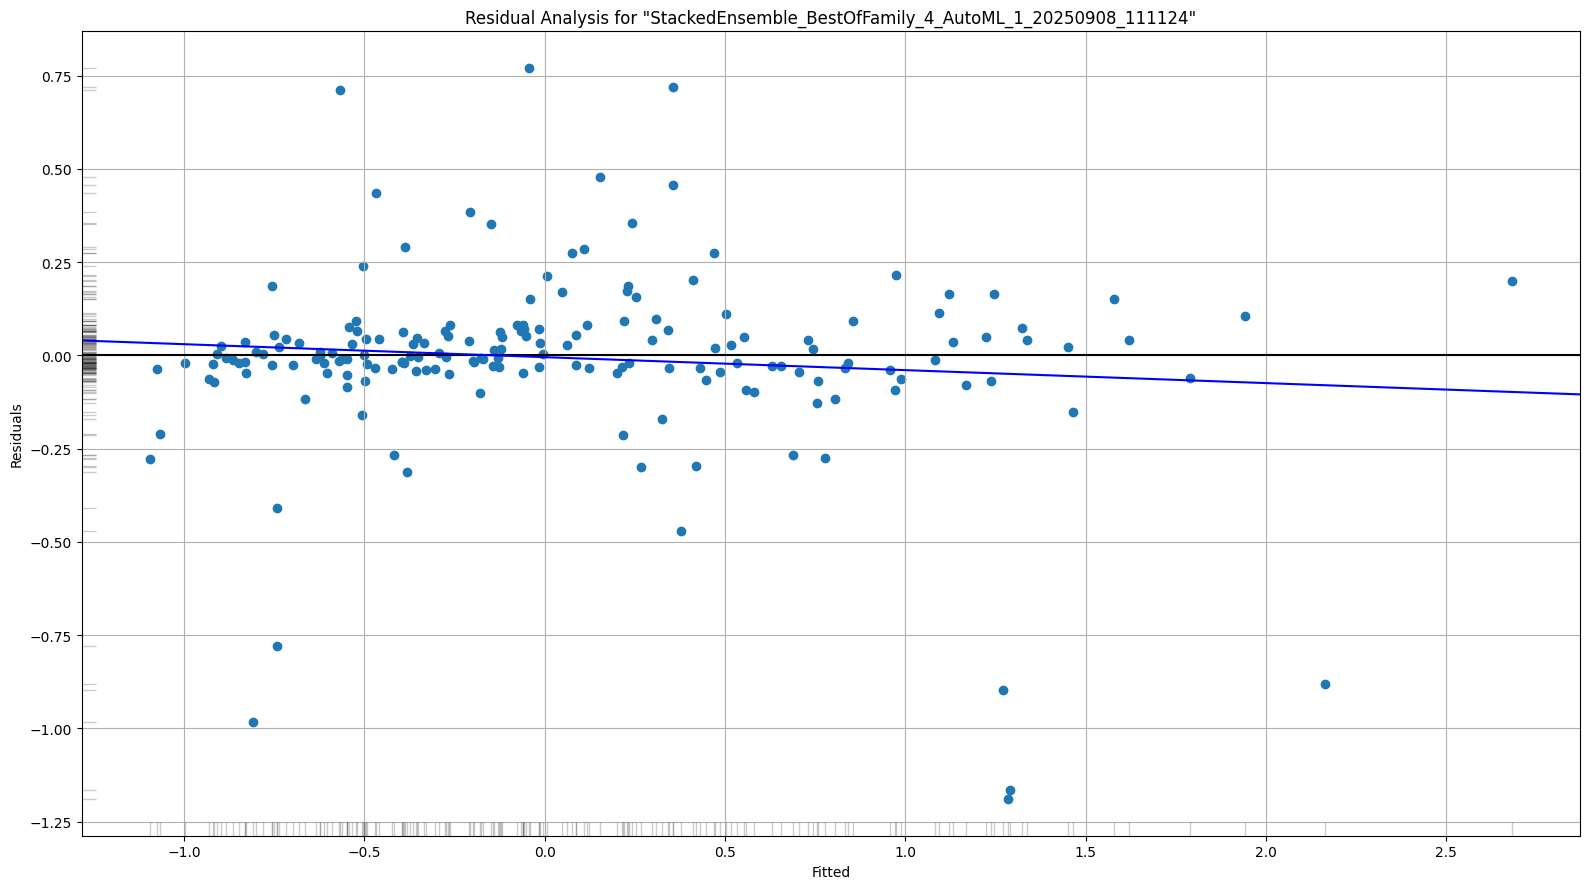

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

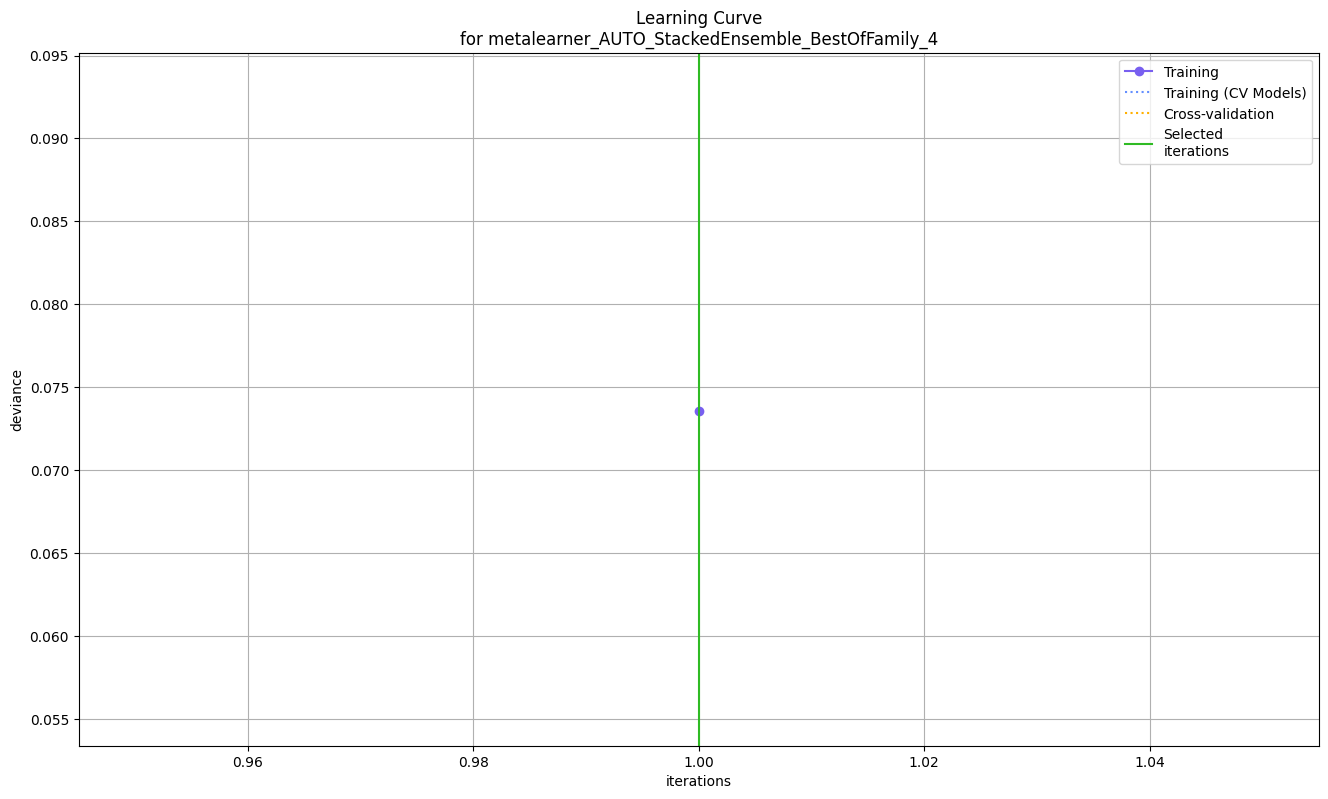

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

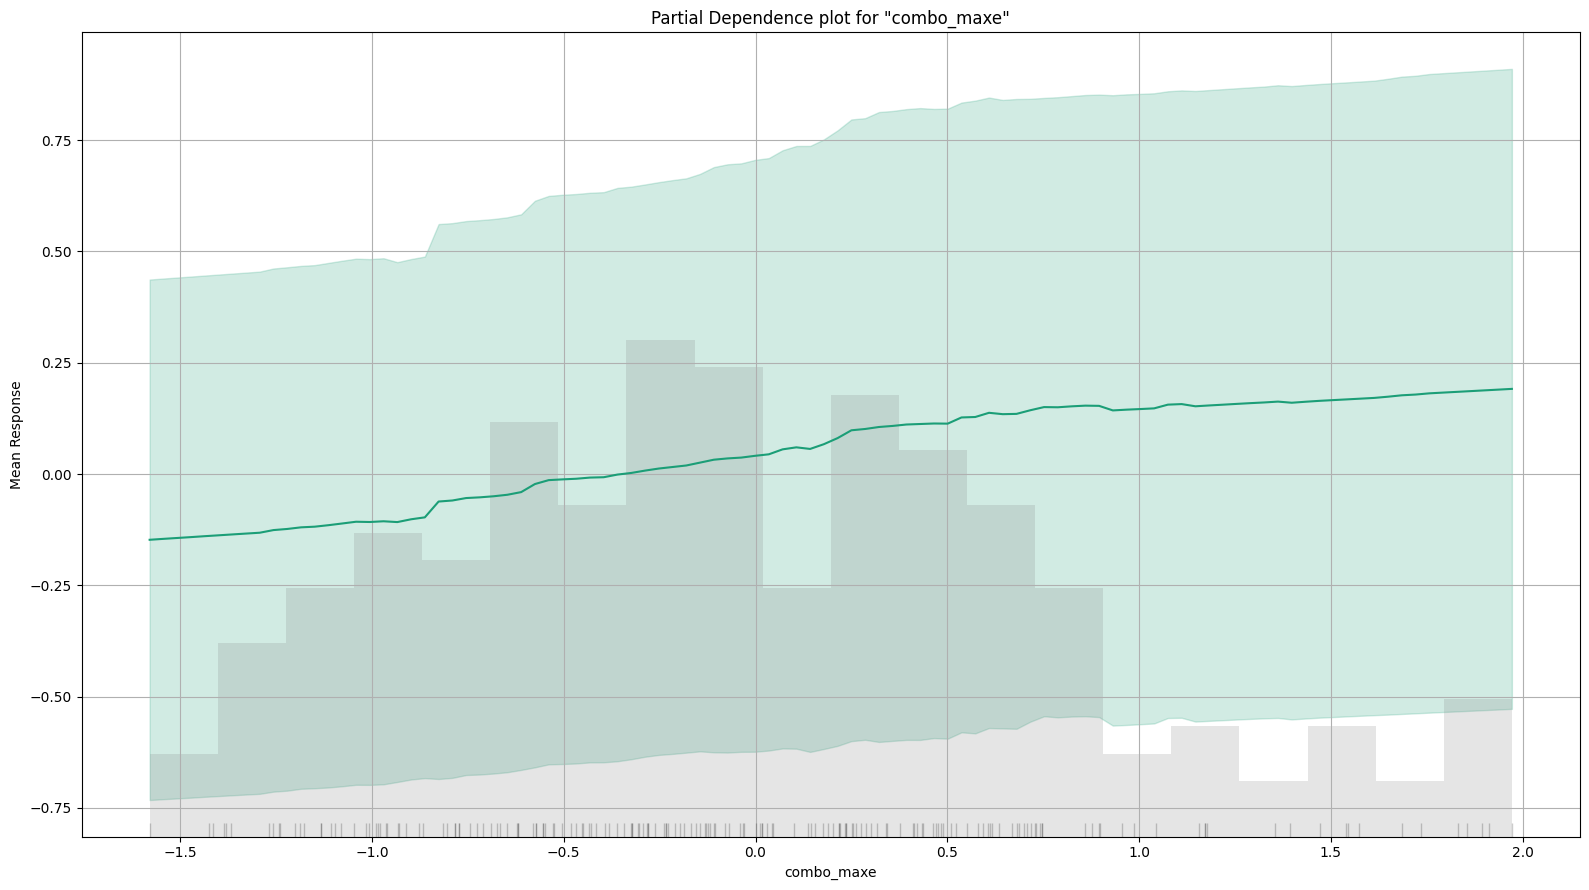

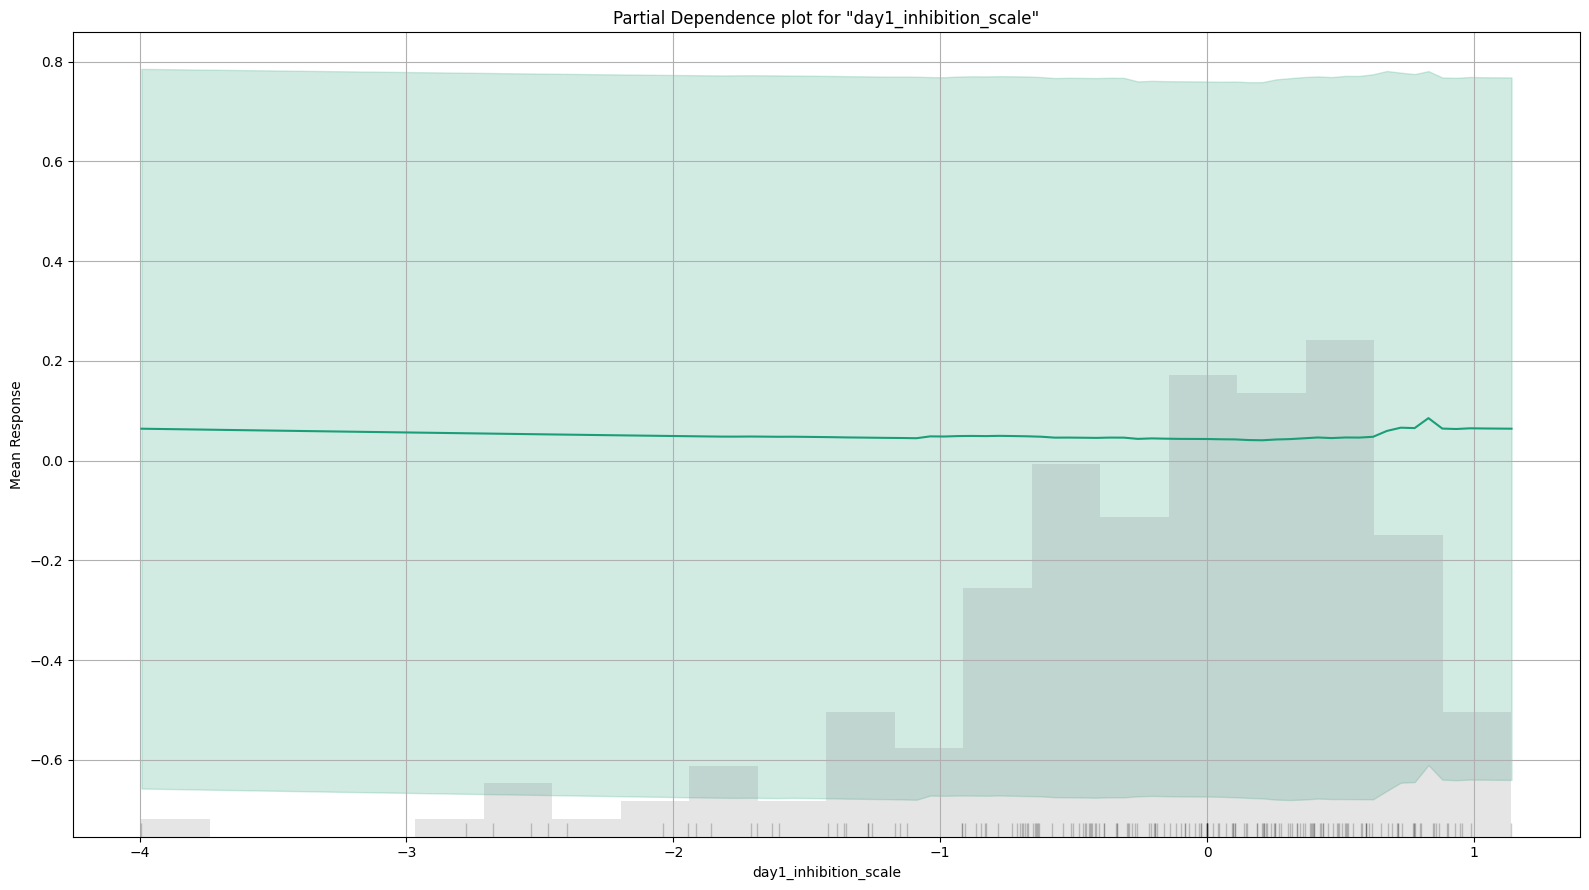

KeyboardInterrupt: 

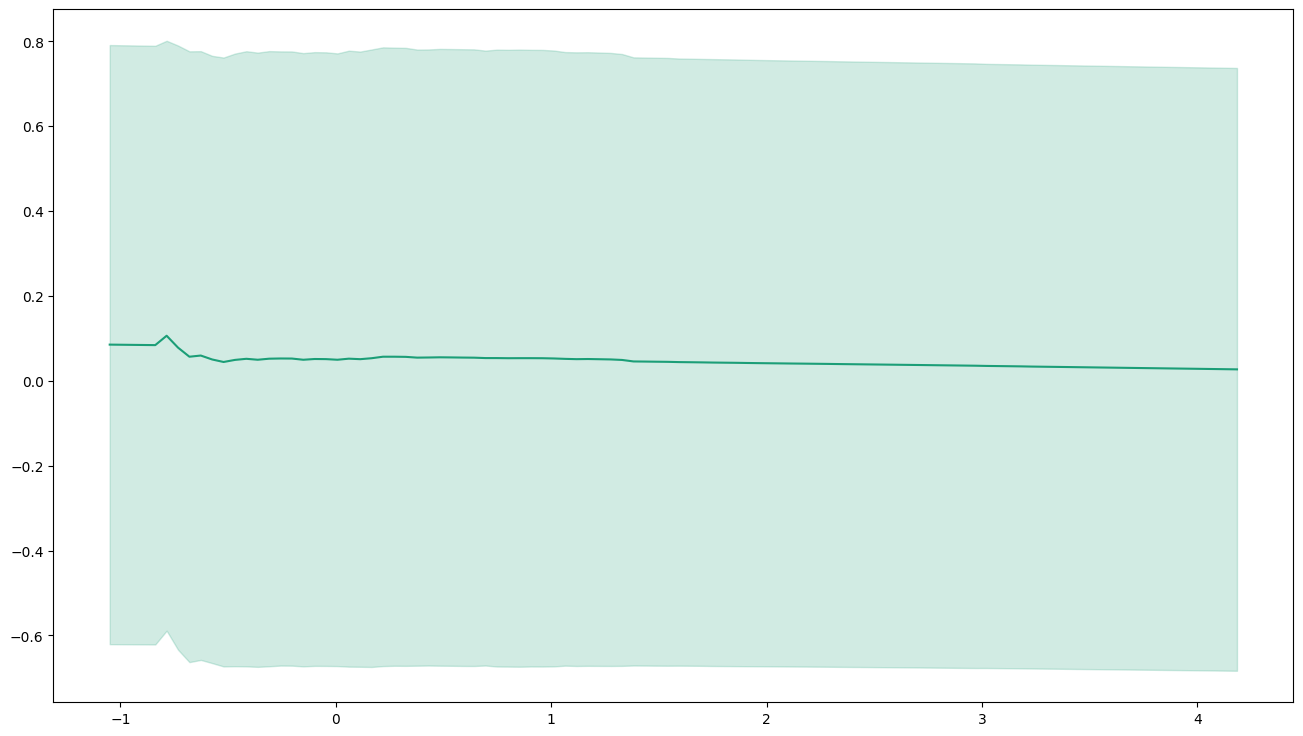

In [12]:
h2o.explain(aml.leader,test)

In [46]:
#Run without cellline name

column_to_remove = 'cellline_name'
df_updated = df.drop(column_to_remove)
df_updated.columns

['bliss_window',
 'combo_maxe',
 'day1_inhibition_scale',
 'day1_intensity_mean',
 'day1_viability_mean',
 'doubling_time',
 'drug1_ic50_ln',
 'drug1_maxe',
 'drug2_ic50_ln',
 'drug2_maxe',
 'growth_rate',
 'tpm_value',
 "cancer_type_B-Cell Non-Hodgkin's Lymphoma",
 'cancer_type_B-Lymphoblastic Leukemia',
 'cancer_type_Biliary Tract Carcinoma',
 'cancer_type_Bladder Carcinoma',
 'cancer_type_Breast Carcinoma',
 "cancer_type_Burkitt's Lymphoma",
 'cancer_type_Cervical Carcinoma',
 'cancer_type_Chondrosarcoma',
 'cancer_type_Chronic Myelogenous Leukemia',
 'cancer_type_Colorectal Carcinoma',
 'cancer_type_Endometrial Carcinoma',
 'cancer_type_Esophageal Adenocarcinoma',
 'cancer_type_Esophageal Squamous Cell Carcinoma',
 "cancer_type_Ewing's Sarcoma",
 'cancer_type_Gastric Carcinoma',
 'cancer_type_Glioblastoma',
 'cancer_type_Head and Neck Carcinoma',
 'cancer_type_Hepatocellular Carcinoma',
 "cancer_type_Hodgkin's Lymphoma",
 'cancer_type_Kidney Carcinoma',
 'cancer_type_Low Grade Glio

In [47]:
train, test = df_updated.split_frame(ratios=[.8], seed=42)

target_column = 'bliss_window'
x=train.columns
x.remove(target_column)

aml_without_cellline = H2OAutoML(max_runtime_secs=1200, seed=42,project_name="bliss_window_prediction_no_cellline")
aml_without_cellline.train(x=x, y=target_column, training_frame=train)

AutoML progress: |
16:22:05.197: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/3
# GBM base models (used / total),1/1
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [48]:
lb = aml_without_cellline.leaderboard
print(lb)

model_id                                                     rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_2_AutoML_2_20250910_162205  0.66888   0.4474    0.511081      nan                  0.4474
GBM_2_AutoML_2_20250910_162205                           0.669492  0.448219  0.517991      nan                  0.448219
StackedEnsemble_AllModels_1_AutoML_2_20250910_162205     0.67194   0.451503  0.512198      nan                  0.451503
GBM_3_AutoML_2_20250910_162205                           0.673109  0.453076  0.516319      nan                  0.453076
DRF_1_AutoML_2_20250910_162205                           0.674219  0.454571  0.515411      nan                  0.454571
GBM_4_AutoML_2_20250910_162205                           0.67816   0.459901  0.51715       nan                  0.459901
StackedEnsemble_BestOfFamily_1_AutoML_2_20250910_162205  0.691224  0.47779   0.528033      nan                  0.47779
GBM_1_AutoML_2_20250910_162205     

In [49]:
#Run only with the top 14

columns_to_keep = ['bliss_window','combo_maxe','day1_intensity_mean','drug1_ic50_ln','tpm_value','drug2_maxe','cancer_type_Lung Adenocarcinoma','drug2_ic50_ln',
'drug1_maxe','day1_viability_mean','day1_inhibition_scale','growth_rate','doubling_time','tissue_Lung','cancer_type_Colorectal Carcinoma']
df_top_14 = df_updated[columns_to_keep]
df_top_14.columns

['bliss_window',
 'combo_maxe',
 'day1_intensity_mean',
 'drug1_ic50_ln',
 'tpm_value',
 'drug2_maxe',
 'cancer_type_Lung Adenocarcinoma',
 'drug2_ic50_ln',
 'drug1_maxe',
 'day1_viability_mean',
 'day1_inhibition_scale',
 'growth_rate',
 'doubling_time',
 'tissue_Lung',
 'cancer_type_Colorectal Carcinoma']

In [50]:
train, test = df_top_14.split_frame(ratios=[.8], seed=42)

target_column = 'bliss_window'
x=train.columns
x.remove(target_column)

aml_top_14 = H2OAutoML(max_runtime_secs=1200, seed=42,project_name="bliss_window_prediction_from_top_14")
aml_top_14.train(x=x, y=target_column, training_frame=train)

AutoML progress: |
18:04:45.951: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [15]:
lb = aml_top_14.leaderboard
print(lb)

model_id                                                     rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_2_20250908_122805  0.642824  0.413223  0.486984      nan                  0.413223
DeepLearning_grid_1_AutoML_2_20250908_122805_model_2     0.648352  0.420361  0.489085      nan                  0.420361
GBM_grid_1_AutoML_2_20250908_122805_model_2              0.666329  0.443995  0.509445      nan                  0.443995
GBM_grid_1_AutoML_2_20250908_122805_model_9              0.669248  0.447893  0.514615      nan                  0.447893
StackedEnsemble_BestOfFamily_2_AutoML_2_20250908_122805  0.670251  0.449236  0.512929      nan                  0.449236
GBM_grid_1_AutoML_2_20250908_122805_model_12             0.671526  0.450947  0.514591      nan                  0.450947
StackedEnsemble_AllModels_2_AutoML_2_20250908_122805     0.673016  0.452951  0.513393      nan                  0.452951
GBM_grid_1_AutoML_2_20250908_122

In [16]:
aml_top_14_one_hour = H2OAutoML(max_runtime_secs=3600, seed=42,project_name="bliss_window_prediction_from_top_14_one_hour")
aml_top_14_one_hour.train(x=x, y=target_column, training_frame=train)

AutoML progress: |
13:01:44.361: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [28]:
#Θα βγαλω λιγα ακομα columns απο το dataset μου
columns_to_keep = ['bliss_window','combo_maxe','day1_intensity_mean','drug1_ic50_ln','tpm_value','drug2_maxe','drug2_ic50_ln',
'drug1_maxe','day1_viability_mean','day1_inhibition_scale','growth_rate','doubling_time']
df_reduced = df_top_14[columns_to_keep]
df_reduced.columns

['bliss_window',
 'combo_maxe',
 'day1_intensity_mean',
 'drug1_ic50_ln',
 'tpm_value',
 'drug2_maxe',
 'drug2_ic50_ln',
 'drug1_maxe',
 'day1_viability_mean',
 'day1_inhibition_scale',
 'growth_rate',
 'doubling_time']

In [30]:
train, test = df_reduced.split_frame(ratios=[.8], seed=42)

target_column = 'bliss_window'
x=train.columns
x.remove(target_column)

aml_reduced = H2OAutoML(max_runtime_secs=1200, seed=42,project_name="bliss_window_prediction_reduced_dataset")
aml_reduced.train(x=x, y=target_column, training_frame=train)

AutoML progress: |███
20:36:44.379: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [31]:
lb = aml_reduced.leaderboard
print(lb)

model_id                                                     rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_4_20250909_203643  0.644507  0.41539   0.488861      nan                  0.41539
DeepLearning_grid_1_AutoML_4_20250909_203643_model_7     0.647279  0.41897   0.488678      nan                  0.41897
DeepLearning_grid_1_AutoML_4_20250909_203643_model_6     0.649483  0.421829  0.485882      nan                  0.421829
DeepLearning_grid_1_AutoML_4_20250909_203643_model_9     0.654421  0.428267  0.489363      nan                  0.428267
StackedEnsemble_AllModels_3_AutoML_4_20250909_203643     0.655645  0.42987   0.495258      nan                  0.42987
GBM_grid_1_AutoML_4_20250909_203643_model_12             0.668399  0.446758  0.5111        nan                  0.446758
DeepLearning_grid_1_AutoML_4_20250909_203643_model_8     0.669756  0.448574  0.50274       nan                  0.448574
StackedEnsemble_BestOfFamily_2_Auto

In [32]:
aml_reduced_hour = H2OAutoML(max_runtime_secs=3600, seed=42,project_name="bliss_window_prediction_reduced_dataset_one_hour")
aml_reduced_hour.train(x=x, y=target_column, training_frame=train)

AutoML progress: |█
21:03:14.876: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# GLM base models (used / total),1/1
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [33]:
lb = aml_reduced_hour.leaderboard
print(lb)

model_id                                                     rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_5_20250909_210314  0.662752  0.43924   0.503177      nan                  0.43924
StackedEnsemble_AllModels_3_AutoML_5_20250909_210314     0.667445  0.445483  0.510387      nan                  0.445483
GBM_grid_1_AutoML_5_20250909_210314_model_12             0.668399  0.446758  0.5111        nan                  0.446758
StackedEnsemble_BestOfFamily_2_AutoML_5_20250909_210314  0.672337  0.452038  0.511491      nan                  0.452038
StackedEnsemble_AllModels_2_AutoML_5_20250909_210314     0.672566  0.452346  0.515112      nan                  0.452346
StackedEnsemble_BestOfFamily_3_AutoML_5_20250909_210314  0.675292  0.45602   0.515232      nan                  0.45602
GBM_grid_1_AutoML_5_20250909_210314_model_10             0.675293  0.456021  0.514193      nan                  0.456021
GBM_grid_1_AutoML_5_20250909_21031